# 23 · Umbralización 

Este cuaderno muestra cómo convertir una imagen a binaria mediante:
- Umbral **Global** 
- **Otsu** 
- **Adaptativa** 


## 1) Teoría breve

La umbralización binaria se define como:\n\[\ng(x,y) = \begin{cases}255,& f(x,y) > T \\ 0,& f(x,y) \le T\end{cases}\n\]\ndonde \(f\) es la intensidad en gris y \(T\) el umbral.\n\n- **Global**: un solo \(T\) para toda la imagen.\n- **Otsu**: elige \(T\) automáticamente maximizando varianza entre clases.\n- **Adaptativa**: calcula \(T\) localmente por vecindarios (iluminación no uniforme).

## 2) Cargar imagen

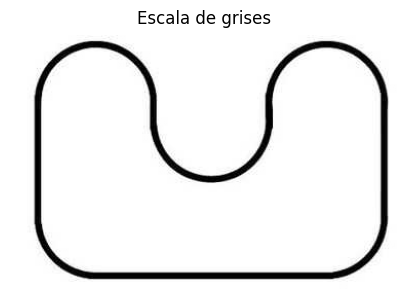

In [10]:
import cv2, numpy as np, matplotlib.pyplot as plt
IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\linea.png"
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,4)); plt.imshow(gray, cmap='gray'); plt.title('Escala de grises'); plt.axis('off'); plt.show()


## 3) Global, Otsu y Adaptativa (ejemplos)

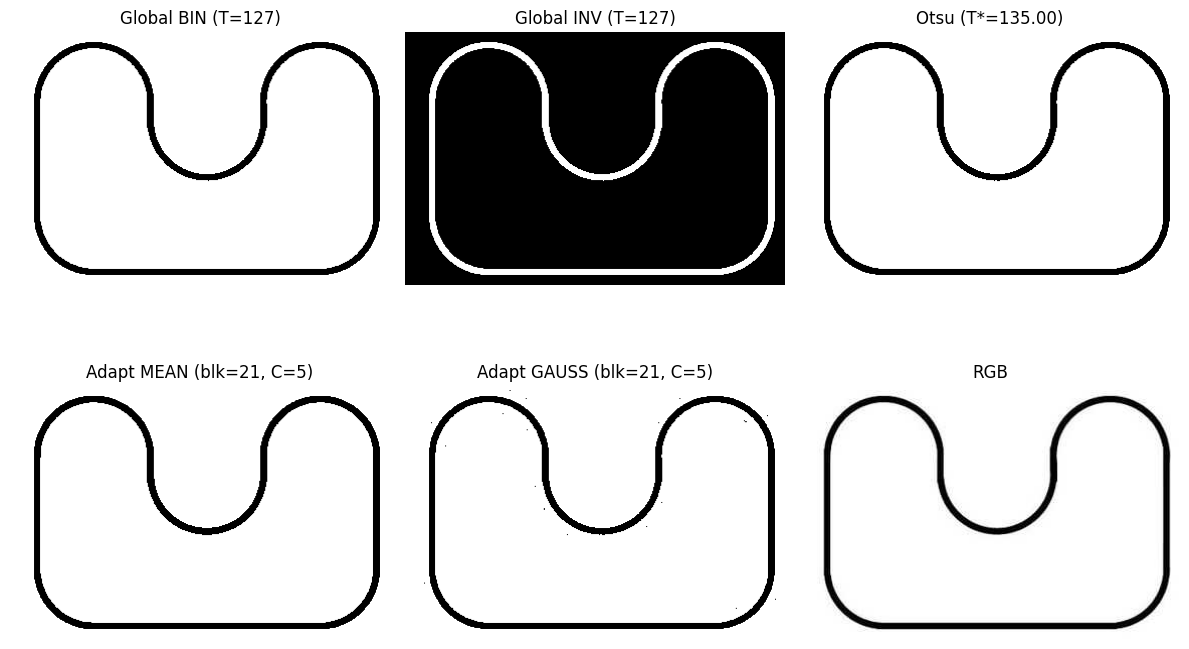

In [11]:
T = 127
_, th_bin = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)
_, th_inv = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY_INV)
T_otsu, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blockSize, C = 21, 5
th_adapt_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, C)
th_adapt_gaus = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)
plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.imshow(th_bin, cmap='gray'); plt.title(f'Global BIN (T={T})'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(th_inv, cmap='gray'); plt.title(f'Global INV (T={T})'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(th_otsu, cmap='gray'); plt.title(f'Otsu (T*={T_otsu:.2f})'); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(th_adapt_mean, cmap='gray'); plt.title(f'Adapt MEAN (blk={blockSize}, C={C})'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(th_adapt_gaus, cmap='gray'); plt.title(f'Adapt GAUSS (blk={blockSize}, C={C})'); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(rgb); plt.title('RGB'); plt.axis('off')
plt.tight_layout(); plt.show()


## 4) Interactivo: sliders

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
w_T = widgets.IntSlider(value=127, min=0, max=255, step=1, description='T (global)')
w_type = widgets.Dropdown(options={'BINARY':cv2.THRESH_BINARY, 'BINARY_INV':cv2.THRESH_BINARY_INV}, value=cv2.THRESH_BINARY, description='Tipo')
w_blk = widgets.IntSlider(value=21, min=3, max=99, step=2, description='blockSize')
w_C = widgets.IntSlider(value=5, min=-20, max=20, step=1, description='C')
w_inv = widgets.Checkbox(value=False, description='Adaptativa inversa')
display(widgets.HBox([w_T, w_type])); display(widgets.HBox([w_blk, w_C, w_inv]))
out = widgets.Output(); display(out)
def refresh(*args):
    with out:
        clear_output(wait=True)
        _, th_global = cv2.threshold(gray, w_T.value, 255, int(w_type.value))
        T_otsu, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ttype = cv2.THRESH_BINARY_INV if w_inv.value else cv2.THRESH_BINARY
        th_m = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, ttype, w_blk.value, w_C.value)
        th_g = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, ttype, w_blk.value, w_C.value)
        plt.figure(figsize=(12,8))
        plt.subplot(2,3,1); plt.imshow(th_global, cmap='gray'); plt.title(f'Global (T={w_T.value})'); plt.axis('off')
        plt.subplot(2,3,2); plt.imshow(th_otsu, cmap='gray'); plt.title(f'Otsu (T*={T_otsu:.2f})'); plt.axis('off')
        plt.subplot(2,3,3); plt.imshow(gray, cmap='gray'); plt.title('Gris'); plt.axis('off')
        plt.subplot(2,3,4); plt.imshow(th_m, cmap='gray'); plt.title(f'Adapt MEAN (blk={w_blk.value}, C={w_C.value})'); plt.axis('off')
        plt.subplot(2,3,5); plt.imshow(th_g, cmap='gray'); plt.title(f'Adapt GAUSS (blk={w_blk.value}, C={w_C.value})'); plt.axis('off')
        plt.subplot(2,3,6); plt.imshow(rgb); plt.title('RGB'); plt.axis('off')
        plt.tight_layout(); plt.show()
for w in [w_T,w_type,w_blk,w_C,w_inv]: w.observe(refresh, names='value')
refresh()


Output()

## 5) Consejos prácticos (robótica)

- **Global**: condiciones de luz uniformes (p.ej., seguidor de línea). Ajusta `T` o usa `BINARY_INV` si la línea es negra.
- **Otsu**: evita calibrar `T` a mano, útil con histograma bimodal (fondo/objeto). Puede fallar si la escena no es bimodal.
- **Adaptativa**: robusta ante sombras o gradientes. `blockSize` define la escala local; `C` ajusta la severidad del umbral.